In [62]:
from dotenv import load_dotenv
load_dotenv()

True

In [63]:
from langgraph.types import Command,Literal
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage,ToolMessage,SystemMessage
from langgraph.graph import MessagesState,START,END,StateGraph,add_messages
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_experimental.tools import PythonREPLTool
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing import Annotated,List,Literal
from typing_extensions import TypedDict
from pprint import pprint
from pydantic import BaseModel,Field
import asyncio
import os

In [64]:
llm= ChatGoogleGenerativeAI(model='gemini-2.0-flash', temperature=0.1)

In [65]:
@tool
def add_worker(a: Annotated[float, "the first number"], b: Annotated[float, "the second number"]) -> float:
    """Adds two numbers together."""
    return a+b

@tool
def subtract_worker(a: Annotated[float, "the first number"], b: Annotated[float, "the second number"]) -> float:
    """Subtracts the second number from the first."""
    return a-b

@tool
def multiply_worker(a: Annotated[float, "the first number"], b: Annotated[float, "the second number"]) -> float:
    """Multiplies two numbers together."""
    return a*b

In [66]:
llm_with_tools = llm.bind_tools([add_worker, subtract_worker, multiply_worker])

In [67]:

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [68]:
tool_node = ToolNode(tools=[add_worker, subtract_worker, multiply_worker])

In [69]:
from typing import Literal

# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["end", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no tool call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [70]:
async def model(state: State):
    messages = state["messages"]
    response = await llm_with_tools.ainvoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [71]:
graph_builder = StateGraph(State)

graph_builder.add_node("supervisor", model)
graph_builder.add_node("calculator", tool_node)


graph_builder.add_edge(START, "supervisor")

graph_builder.add_conditional_edges("supervisor",should_continue,{
    'end':END,
    'continue':"calculator"
})                                  

graph_builder.add_edge("calculator", "supervisor")

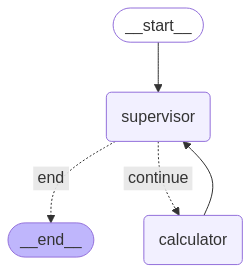

In [72]:
graph_builder.compile()

In [73]:
graph = graph_builder.compile()

In [74]:

input = {"messages": [HumanMessage(content="what is 2+2? and 5*5? and 10-3?")]}


await graph.ainvoke(input)

{'messages': [HumanMessage(content='what is 2+2? and 5*5? and 10-3?', additional_kwargs={}, response_metadata={}, id='80525f37-c499-4101-bafc-968f09062c3e'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'subtract_worker', 'arguments': '{"a": 10.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8b2fe62e-a2fc-4b58-a00a-719fadcc536c-0', tool_calls=[{'name': 'add_worker', 'args': {'a': 2.0, 'b': 2.0}, 'id': '9b67cace-09b3-4df2-a7c5-b8b3605882da', 'type': 'tool_call'}, {'name': 'multiply_worker', 'args': {'a': 5.0, 'b': 5.0}, 'id': 'd8af6aa5-677c-412e-b96b-57b4dc637634', 'type': 'tool_call'}, {'name': 'subtract_worker', 'args': {'a': 10.0, 'b': 3.0}, 'id': 'af461d87-2cbf-45bf-8415-9ede7dab4ff6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 15, 'total_tokens': 95, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='4.0',

In [75]:
input_2 = {"messages": [HumanMessage(content="what is 1000000+1141351 and 5325125*54? and 1012515135125-31352515?")]}


In [76]:
response = await graph.ainvoke(input_2)

In [77]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

what is 1000000+1141351 and 5325125*54? and 1012515135125-31352515?
================================== Ai Message ==================================
Tool Calls:
  add_worker (cb784f68-feeb-46b5-a10a-21a14e3cb87e)
 Call ID: cb784f68-feeb-46b5-a10a-21a14e3cb87e
  Args:
    a: 1000000.0
    b: 1141351.0
  multiply_worker (99f3a016-a452-42ca-8bf3-a5584d273d9f)
 Call ID: 99f3a016-a452-42ca-8bf3-a5584d273d9f
  Args:
    a: 5325125.0
    b: 54.0
  subtract_worker (6896c8b0-0ac7-4fff-af88-fa0cf932d068)
 Call ID: 6896c8b0-0ac7-4fff-af88-fa0cf932d068
  Args:
    a: 1012515135125.0
    b: 31352515.0
================================= Tool Message =================================
Name: add_worker

2141351.0
================================= Tool Message =================================
Name: multiply_worker

287556750.0
================================= Tool Message =================================
Name: subtract_w